## Importação das bibliotecas

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import mapclassify as mc
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from shapely.geometry.point import Point
import seaborn as sns

import math

## Análise dos dados

In [2]:
# Configurações do pandas
pd.options.mode.chained_assignment = None    # default='warn'  --> opção None

In [3]:
#Diretório para leitura de arquivos e salvamento de resultados

bacia = 'atibaia_cabeceira'
# bacia = 'camanducaia'
# bacia = 'capivari'
# bacia = 'corumbatai'
# bacia = 'jundiai'


path = 'D:/projetos_qswatmod/' + f'{bacia}' + '/outputs/'
results_path = 'D:/projetos_qswatmod/' + f'{bacia}' + '/resultados/'

In [4]:
#Camada vetorial da recarga do modelo MODFLOW
rch_modflow = gpd.read_file(path + 'mf_rch_monthly.geojson')

#Camada vetorial dos limites da referida bacia hidrográfica
boundaries = gpd.read_file(path + 'boundary.geojson')

#Camada da rede de drenagem das bacias PCJ
rede_drenagem = gpd.read_file('D:/projetos_qswatmod/shapes/rede_drenagem.geojson')
rede_drenagem = rede_drenagem.to_crs(epsg='4674')

#Cópia da camada vetorial dos limites da bacia hidrográfica para recorte
boundaries_gcs = boundaries.copy(deep=True)
boundaries_gcs = boundaries_gcs.to_crs(epsg='4674')

#Camada vetorial dos limites municipais de SP
SP_municipios = gpd.read_file('D:/projetos_qswatmod/shapes/SP_Municipios_2020.shp')

In [5]:
rch_modflow.head(2)

,fid,VALUE,grid_id,elev_count,elev_sum,elev_mf,row,col,Jan-1980,Feb-1980,...,Apr-2020,May-2020,Jun-2020,Jul-2020,Aug-2020,Sep-2020,Oct-2020,Nov-2020,Dec-2020,geometry
0,1,0.0,1,0.0,0.0,NaN,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((340618.769 7472826.657, 340868.769 7..."
1,2,0.0,2,0.0,0.0,NaN,1,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((340868.769 7472826.657, 341118.769 7..."


In [6]:
n_row = rch_modflow.iloc[-1, 6].astype('str')
n_col = rch_modflow.iloc[-1, 7].astype('str')

print(f'A grade do MODFLOW (sem recortar) da bacia {bacia.upper()} tem: \n{n_row} linhas \n{n_col} colunas \n{len(rch_modflow)} células')

A grade do MODFLOW (sem recortar) da bacia ATIBAIA_CABECEIRA tem: 
198 linhas 
211 colunas 
41778 células


In [7]:
print(f'rch_modflow: {rch_modflow.crs} \nboundaries: {boundaries.crs} \nboundaries_gcs: {boundaries_gcs.crs} \nSP_municipios: {SP_municipios.crs} \nRede drenagem: {rede_drenagem.crs}')

rch_modflow: EPSG:32723 
boundaries: EPSG:32723 
boundaries_gcs: EPSG:4674 
SP_municipios: EPSG:4674 
Rede drenagem: EPSG:4674


In [8]:
municipios_bacia = gpd.clip(SP_municipios, boundaries_gcs, keep_geom_type=True)
municipios_bacia.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

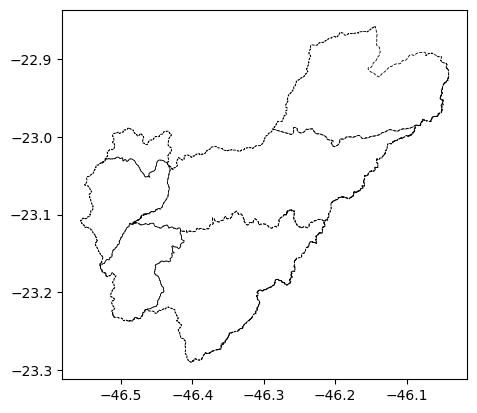

In [9]:
municipios_bacia.boundary.plot(color='k', lw=0.6, ls='--')

In [10]:
type(municipios_bacia)

geopandas.geodataframe.GeoDataFrame

In [11]:
print(f'Camada vetorial MODFLOW (Bacia: {bacia.upper()}):\n{type(rch_modflow)}\nshape (lin, col): {rch_modflow.shape}\n\n')
print(f'Camada limites da bacia {bacia.upper()}:\n{type(boundaries)}\nshape (lin, col): {boundaries.shape}')

Camada vetorial MODFLOW (Bacia: ATIBAIA_CABECEIRA):
<class 'geopandas.geodataframe.GeoDataFrame'>
shape (lin, col): (41778, 501)


Camada limites da bacia ATIBAIA_CABECEIRA:
<class 'geopandas.geodataframe.GeoDataFrame'>
shape (lin, col): (1, 19)


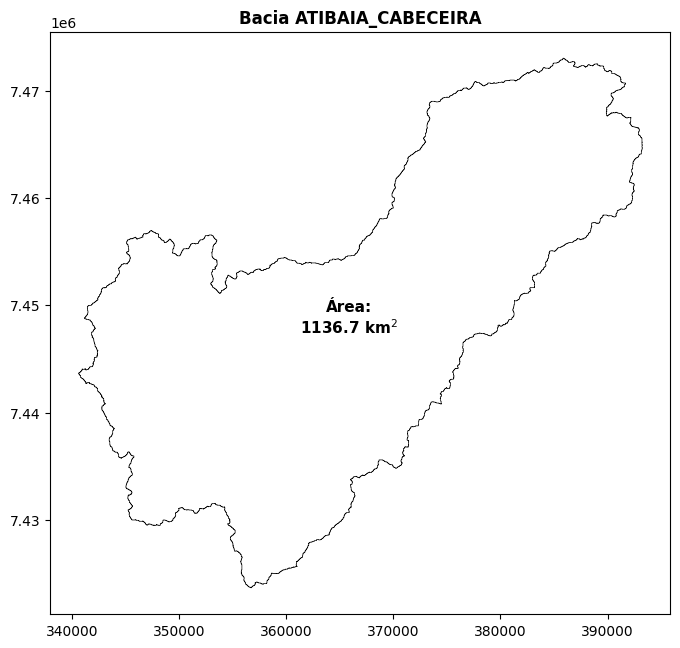

In [12]:
#Calculando a área da bacia em km^2
boundaries_coord_metricas = boundaries.copy(deep=True)
boundaries_coord_metricas.to_crs(epsg='32723', inplace=True)#pode retirar, já está em utm
boundaries_coord_metricas['area_km2'] = boundaries_coord_metricas['geometry'].area / 10**6
area_bacia_km2 = boundaries_coord_metricas.loc[0, 'area_km2']

#Calculando as coordenadas do centroide do polígono
boundaries['x'] = boundaries['geometry'].centroid.x
boundaries['y'] = boundaries['geometry'].centroid.y
x_coord = boundaries.loc[0, 'x']
y_coord = boundaries.loc[0, 'y']

#Plotando os limites da bacia hidrográfica
fig, ax1 = plt.subplots(figsize=(8, 8))

boundaries.boundary.plot(ax=ax1, color='k', lw=0.5, ls='-')

ax1.set_title(f'Bacia {bacia.upper()}', fontsize=12, color='k', weight='bold')
ax1.text(x_coord, y_coord, f'Área:\n{area_bacia_km2:.1f} km$^{2}$', va='center', ha='center', color='k', fontsize=11, fontweight='bold', bbox=dict(facecolor='w', alpha=0.6, edgecolor='w', ls='-'))    # transform=ax1.transAxes


#Salvando o mapa
plt.savefig(results_path + 'mapa_limites_bacia.png', facecolor='w', bbox_inches='tight', dpi=300)

plt.show()

<Axes: >

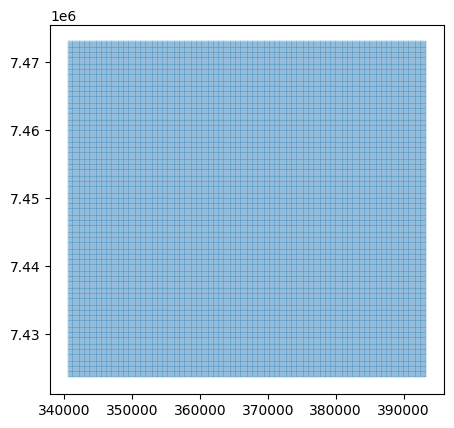

In [13]:
#Camada vetorial do grid MODFLOW
rch_modflow.boundary.plot(lw=0.3, alpha=0.7)

In [14]:
rch_modflow = gpd.clip(rch_modflow, boundaries, keep_geom_type=True)

rch_modflow.reset_index(drop=True, inplace=True)
rch_modflow['id'] = rch_modflow.index

In [15]:
print(f'Camada vetorial MODFLOW (Bacia: {bacia.upper()}) recortada:\nTipo: {type(rch_modflow)}\nShape do gdf (lin, col): {rch_modflow.shape}')

Camada vetorial MODFLOW (Bacia: ATIBAIA_CABECEIRA) recortada:
Tipo: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape do gdf (lin, col): (18737, 502)


In [16]:
print(f'Existem {len(rch_modflow)} células na grade MODFLOW da camada recortada.')

Existem 18737 células na grade MODFLOW da camada recortada.


<Axes: >

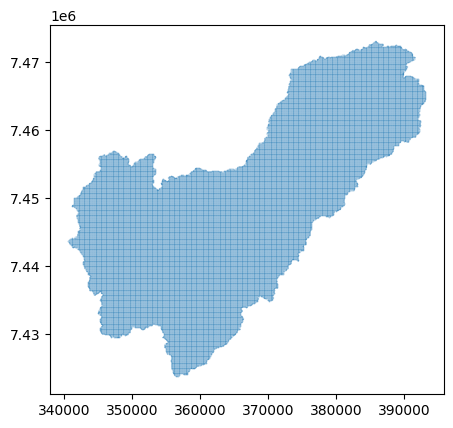

In [17]:
rch_modflow.boundary.plot(lw=0.3, alpha=0.7)

#### Conversão dos dados de recarga
- Os dados do SWAT-MODFLOW saem em m^3/dia

In [18]:
"""
Anteriormente, a seleção das colunas dos meses e criação da coluna de média estava sendo feita da seguinte forma:
df_media['mean'] = df_media.loc[:, 'Jan-1980': 'Dec-2020'].mean(axis=1)
"""

df_media = rch_modflow.copy(deep=True)

df_media = df_media.loc[:, 'Jan-1985': 'Dec-2020']
df_media = df_media.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
df_media['mean'] = df_media.mean(axis=1)
df_media = df_media[['mean']]

rch_modflow = pd.concat([rch_modflow, df_media], axis=1)

#Conferindo se o resultado é um geodataframe do Geopandas
print(f'A camada vetorial MODFLOW é um {type(rch_modflow)}')

A camada vetorial MODFLOW é um <class 'geopandas.geodataframe.GeoDataFrame'>


In [19]:
rch_modflow.head()

,fid,VALUE,grid_id,elev_count,elev_sum,elev_mf,row,col,Jan-1980,Feb-1980,...,Jun-2020,Jul-2020,Aug-2020,Sep-2020,Oct-2020,Nov-2020,Dec-2020,geometry,id,mean
0,37861,0.0,37861,6.0,6967.0,1161.166667,180,92,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((363368.769 7428326.657, 363478.769 7...",0,0.0
1,37652,0.0,37652,4.0,4911.0,1227.750000,179,94,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((363868.769 7428576.657, 363988.769 7...",1,0.0
2,37650,0.0,37650,65.0,74063.0,1139.430769,179,92,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((363368.769 7428326.657, 363368.769 7...",2,0.0
3,37651,0.0,37651,15.0,17801.0,1186.733333,179,93,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((363618.769 7428576.657, 363868.769 7...",3,0.0
4,37440,0.0,37440,64.0,73288.0,1145.125000,178,93,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((363618.769 7428826.657, 363868.769 7...",4,0.0


#### Outras métricas

In [20]:
rch_modflow.isnull().sum()

fid           0
VALUE         0
grid_id       0
elev_count    0
elev_sum      0
             ..
Nov-2020      0
Dec-2020      0
geometry      0
id            0
mean          0
Length: 503, dtype: int64

In [21]:
print(f'Tem {rch_modflow.isnull().sum().sum()} valores nulos no gdf.')

Tem 0 valores nulos no gdf.


In [22]:
rch_modflow['mean'].describe()

count    18737.000000
mean        20.822930
std          8.136115
min          0.000000
25%         16.342904
50%         21.187473
75%         25.770760
max         64.945332
Name: mean, dtype: float64

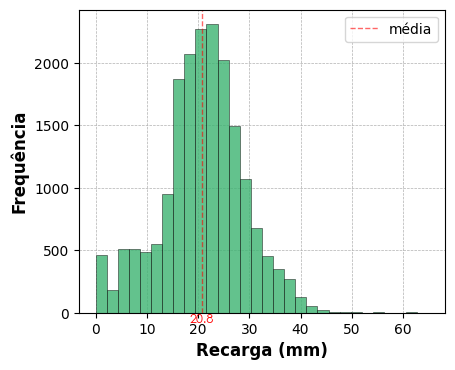

In [23]:
#Configurando a figura
cm = 1/2.54
plt.figure(figsize=(12*cm, 10*cm))

media_1 = round(rch_modflow['mean'].mean(), 1)

rch_modflow['mean'].hist(bins=30, color='mediumseagreen', edgecolor='k', lw=0.4, alpha=0.8, zorder=2)
# plt.title(f'Histograma de recarga do modelo MODFLOW ({bacia.upper()})', fontsize=11, fontweight='bold')
plt.xlabel('Recarga (mm)', fontsize=12, weight='bold')
plt.ylabel('Frequência', fontsize=12, weight='bold')
plt.grid(True, lw=0.5, ls='--', zorder=1)
plt.axvline(x=media_1, color='r', lw=1.0, ls='--', alpha=0.6, label='média')
plt.text(media_1, -50, f'{media_1}', va='center', ha='center', color='r', fontsize=9, fontweight='light', fontname='Century Gothic')
plt.legend()

plt.savefig(results_path + 'hist_rec_mod_media_mensal.png', facecolor='w', bbox_inches='tight', dpi=300)

plt.show()

In [24]:
#Cópia do gdf para criar um df de totais
df_total = rch_modflow.copy(deep=True)

#Filtro de anos
df_total = df_total.loc[:, 'Jan-2020': 'Dec-2020']

#Somatório através das colunas
df_total['Total'] = df_total.sum(axis=1)

#Somatório através das linhas
df_total.loc['Total'] = df_total.sum(axis=0)

#Obtendo o total geral --> recarga total na bacia em questão
total_rec = df_total.iloc[-1, -1]

print(f'Recarga total anual em toda a bacia {bacia.upper()}: {round(total_rec, 0)} m^3')

Recarga total anual em toda a bacia ATIBAIA_CABECEIRA: 7628046.0 m^3


In [25]:
total_rec = df_total.iloc[-1, -1]

print(round(total_rec, 0))

7628046.0


## Visualizando em mapas --> <font color=yellow>**Métodos de classificação de dados**</font>

In [26]:
#Reprojetando a camada para coordenadas geográficas
rch_modflow = rch_modflow.to_crs(epsg='4674')
boundaries = boundaries.to_crs(epsg='4674')   #já tem um gdf em geográficas

#### Quantile

No método de classificação por quantis, cada classe contém um número igual de feições. Esse método é adequado para dados distribuídos linearmente. Não há classes vazias, ou classes com poucos ou muitos valores. Ver este [link](https://pro.arcgis.com/en/pro-app/latest/help/mapping/layer-properties/data-classification-methods.htm) para saber mais.

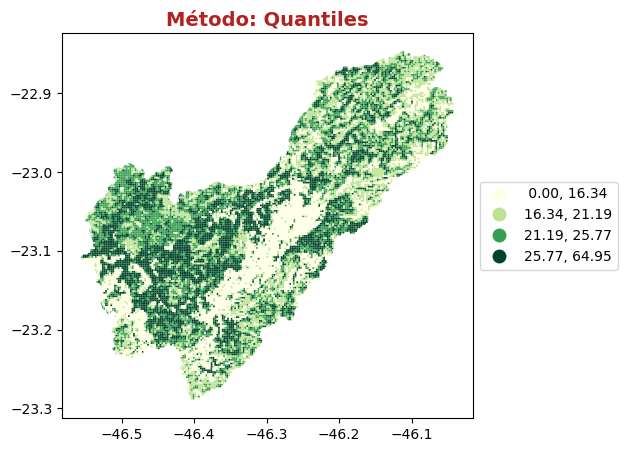

In [27]:
#Plotando o mapa --> esquema Quantis
rch_modflow.plot(column='mean', scheme='Quantiles', k=4, cmap='YlGn', figsize=(10, 5), legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1.0, 0.5)})
plt.title('Método: Quantiles', color='firebrick', fontsize=14, fontweight='bold')

plt.show()

#### Equal interval

Este método usa intervalos iguais para dividir a faixa de valores em subfaixas de igual tamanho. Isso permite que você especifique o número de intervalos, e as quebras de classe baseadas no intervalo de valores são determinadas automaticamente. Por exemplo, se você especificar três classes para um campo cujos valores variam de 0 a 300, serão criadas três classes com intervalos de 0-100, 101-200 e 201-300. Ver este [link](https://pro.arcgis.com/en/pro-app/latest/help/mapping/layer-properties/data-classification-methods.htm) para saber mais.

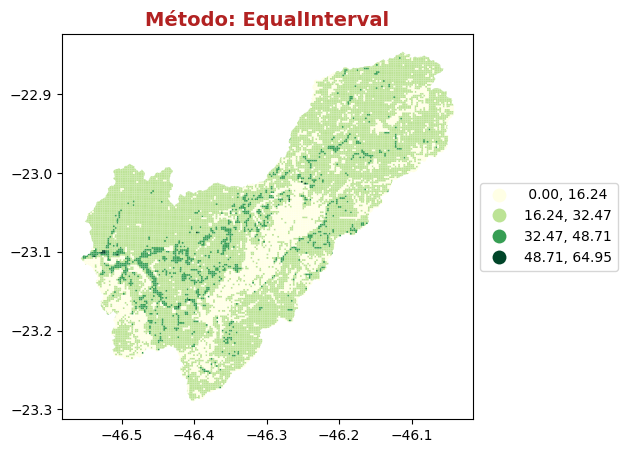

In [28]:
#Plotando o mapa --> esquema Intervalos iguais
rch_modflow.plot(column='mean', scheme='EqualInterval', k=4, cmap='YlGn', figsize=(10, 5), legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1.0, 0.5)})
plt.title('Método: EqualInterval', color='firebrick', fontsize=14, fontweight='bold')

plt.show()

#### Natural breaks (Jenks)

Com a classificação por quebras naturais, as classes são baseadas em agrupamentos naturais inerentes aos dados. As quebras de classe são criadas de forma a agrupar melhor os valores semelhantes e maximizar as diferenças entre as classes. Os recursos são divididos em classes cujos limites são definidos onde há diferenças relativamente grandes nos valores dos dados. Ver este [link](https://pro.arcgis.com/en/pro-app/latest/help/mapping/layer-properties/data-classification-methods.htm) para saber mais.

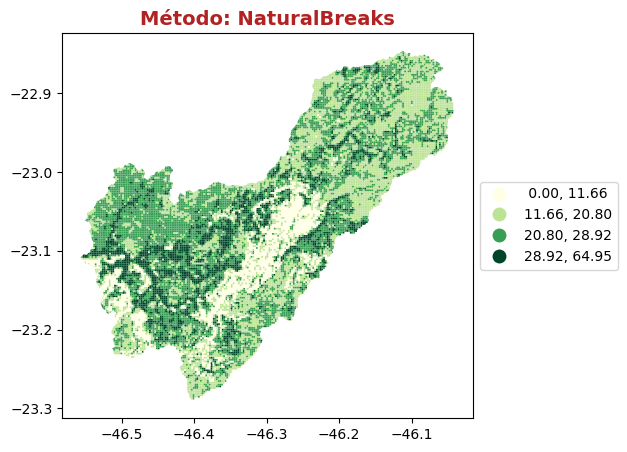

In [29]:
#Plotando o mapa --> esquema Quebras Naturais
rch_modflow.plot(column='mean', scheme='NaturalBreaks', k=4, cmap='YlGn', figsize=(10, 5), legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1.0, 0.5)})
plt.title('Método: NaturalBreaks', color='firebrick', fontsize=14, fontweight='bold')

plt.show()

## Mapa (<font color=yellow>**TESE**</font>)

#### Selecionando os municípios

In [30]:
for num, muni in enumerate(municipios_bacia['NM_MUN'].sort_values()):
    print(num + 1, muni)

1 Atibaia
2 Bom Jesus dos Perdões
3 Bragança Paulista
4 Guarulhos
5 Igaratá
6 Joanópolis
7 Nazaré Paulista
8 Piracaia
9 Santa Isabel
10 São José dos Campos


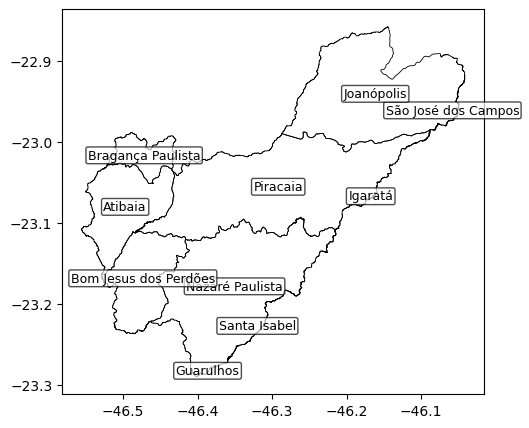

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))

municipios_bacia.boundary.plot(ax=ax, color='k', lw=0.6, ls='-', label='Municípios', zorder=3)
municipios_bacia.apply(lambda x: ax.annotate(text=x['NM_MUN'], xy=x.geometry.centroid.coords[0], fontsize=9, ha='center', va='center', bbox=dict(boxstyle='round, pad=0.15', facecolor='white', alpha=0.7)), axis=1)

plt.show()

In [32]:
"""
Listas de municípios selecionados para aparecerem como rótulos nos mapas individuais.
"""


if bacia == 'atibaia_cabeceira':
    lista_muni_selecionados = ['Atibaia', 'Piracaia', 'Joanópolis', 'Nazaré Paulista']
    print(f'BACIA: {bacia.upper()}\n')
    for numero, municipio in enumerate(lista_muni_selecionados):
        print(numero + 1, municipio)
elif bacia == 'camanducaia':
    lista_muni_selecionados = ['Jaguariúna', 'Amparo', 'Pinhalzinho', 'Pedra Bela']
    print(f'BACIA: {bacia.upper()}\n')
    for numero, municipio in enumerate(lista_muni_selecionados):
        print(numero + 1, municipio)
elif bacia == 'capivari':
    lista_muni_selecionados = ['Capivari', 'Elias Fausto', 'Monte Mor', 'Campinas', 'Louveira']
    print(f'BACIA: {bacia.upper()}\n')
    for numero, municipio in enumerate(lista_muni_selecionados):
        print(numero + 1, municipio)
elif bacia == 'corumbatai':
    lista_muni_selecionados = ['Analândia', 'Corumbataí', 'Rio Claro', 'Piracicaba', 'Itirapina', 'Ipeúna']
    print(f'BACIA: {bacia.upper()}\n')
    for numero, municipio in enumerate(lista_muni_selecionados):
        print(numero + 1, municipio)
else:
    lista_muni_selecionados = ['Salto', 'Itu', 'Indaiatuba', 'Cabreúva', 'Itupeva', 'Jundiaí', 'Atibaia', 'Jarinu']
    print(f'BACIA: {bacia.upper()}\n')
    for numero, municipio in enumerate(lista_muni_selecionados):
        print(numero + 1, municipio)


BACIA: ATIBAIA_CABECEIRA

1 Atibaia
2 Piracaia
3 Joanópolis
4 Nazaré Paulista


In [33]:
muni_selecionados = municipios_bacia.copy(deep=True)

muni_selecionados = muni_selecionados[muni_selecionados['NM_MUN'].isin(lista_muni_selecionados)]

#### Escala cartográfica (variável: 'distance_meters')

In [34]:
#Calculando a distância entre dois pontos de longitude diferentes para criar a escala cartográfica

points = gpd.GeoSeries([Point(-47.5, -22.8), Point(-46.5, -22.8)], crs=4674)    #  --> Geographic WGS 84 - degrees
points = points.to_crs(32723)    #  --> Projected WGS 84 - meters

distance_meters = points[0].distance(points[1])
print(f'Distância:\n\n{round(distance_meters, 2)} m\nou\n{round(distance_meters / 1000, 2)} km')

Distância:

102686.27 m
ou
102.69 km


#### Definindo as classes e respectivas cores para o mapa

In [35]:
# Opções de classificação dos valores --> Quantiles, EqualInterval, NaturalBreaks
q4_Q = mc.Quantiles(rch_modflow['mean'], k=4)
q4_EI = mc.EqualInterval(rch_modflow['mean'], k=4)
q4_NB = mc.NaturalBreaks(rch_modflow['mean'], k=4)

print(q4_Q, '\n\n', q4_EI, '\n\n', q4_NB)

Quantiles

   Interval      Count
----------------------
[ 0.00, 16.34] |  4685
(16.34, 21.19] |  4684
(21.19, 25.77] |  4684
(25.77, 64.95] |  4684 

 EqualInterval

   Interval      Count
----------------------
[ 0.00, 16.24] |  4594
(16.24, 32.47] | 12855
(32.47, 48.71] |  1275
(48.71, 64.95] |    13 

 NaturalBreaks

   Interval      Count
----------------------
[ 0.00, 11.75] |  2376
(11.75, 20.90] |  6670
(20.90, 29.00] |  7139
(29.00, 64.95] |  2552


In [36]:
"""
Foi definido que serão usadas as mesmas faixas de valores para todas as sub-bacias da PCJ.
Essas faixas (classes) foram definidas se baseando no método de classificação de dados "Natural breaks"

[15, 30, 45, 1000]

"""

#Definindo as faixas de valores e seus respectivos rótulos
referencia = [15, 30, 45, 1000]    # --> [30, 60, 90, 1000]
labels = ['0 - 15', '15 - 30', '30 - 45', '> 45']    # --> ['0 - 30', '30 - 60', '60 - 90', '> 90']
valores = rch_modflow['mean']

classdef = mc.UserDefined(valores, referencia)
cl = [labels[i] for i in classdef.yb]
rch_modflow = rch_modflow.assign(cl=cl)
rch_modflow.cl = pd.Categorical(rch_modflow.cl, ordered=True, categories=labels)

In [37]:
#Lista de cores

colors = ['#c8e59b', '#79c677', '#278042', '#00381d']    # Tons de verde alternativos --> ['#92D050', '#5AC135', '#007600', '#0E3A13']
n_bins = 4
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

#### Rede hidrográfica

In [38]:
rede_drenagem2 = rede_drenagem.copy(deep=True)

In [39]:
rede_drenagem2.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

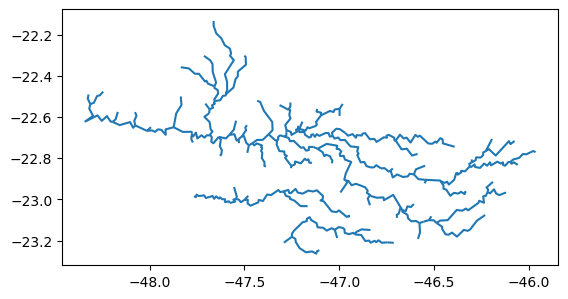

In [40]:
rede_drenagem2.plot()

In [41]:
rede_drenagem2 = gpd.clip(rede_drenagem2, boundaries_gcs, keep_geom_type=True)

<Axes: >

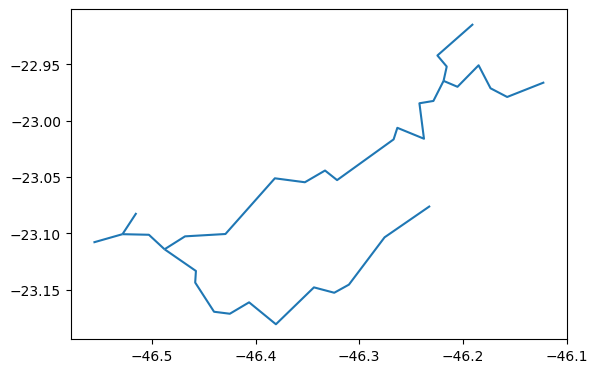

In [42]:
rede_drenagem2.plot()

In [43]:
print(rede_drenagem2.crs)

EPSG:4674


#### Mapa sem municípios

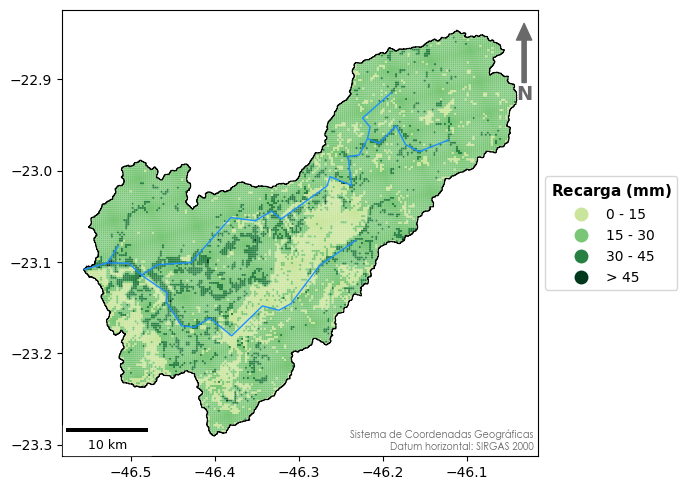

In [44]:
#Configurando a figura
fig, ax = plt.subplots(figsize=(10, 5), layout='tight')    # layout='constrained'

######################################################################
#Plotando o mapa da RECARGA DE AQUÍFERO
rch_modflow.plot(ax=ax, column='cl', cmap=cmap, legend=True, legend_kwds={'title': '$\\bf{Recarga _ (mm)}$',
                                                                            'title_fontsize': 11,
                                                                            'loc': 'center left',
                                                                            'bbox_to_anchor': (1.0, 0.5),
                                                                            'fontsize': 10,
                                                                            'fmt': '{:.1f}',
                                                                            'frameon': True}, zorder=1)

#Plotando os LIMITES DA BACIA
boundaries.boundary.plot(ax=ax, color='k', lw=0.8, ls='-', label='Limites', zorder=2)

#Plotando a rede de drenagem
rede_drenagem2.plot(ax=ax, color='dodgerblue', lw=1.0, ls='-', label='Rede hidrorgráfica', zorder=3)

#Título da figura (superior)
# fig.suptitle('Mapa de recarga', fontsize=16, color='k', weight='bold')

#Seta do Norte
x, y, arrow_length = 0.97, 0.97, 0.16
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='dimgray', edgecolor='dimgray', width=3, headwidth=11),
            ha='center', va='center', fontsize=14, color='dimgray', weight='bold',
            xycoords=ax.transAxes)

#Escala cartográfica
scalebar = ScaleBar(distance_meters, location='lower left', font_properties={'size': 9})
ax.add_artist(scalebar)

#Textos no mapa
plt.text(0.99, 0.01, 'Sistema de Coordenadas Geográficas\nDatum horizontal: SIRGAS 2000', transform=ax.transAxes, va='bottom', ha='right', color='k', fontsize=7, fontweight='light', fontname='Century Gothic', alpha=0.6)
# plt.text(0.5, 0.01, 'Sistema de Coordenadas Geográficas\nDatum horizontal: SIRGAS 2000', transform=ax.transAxes, va='bottom', ha='center', color='k', fontsize=7, fontweight='light', fontname='Century Gothic', alpha=0.6)

#Salvando o mapa
plt.savefig(results_path + 'mapa_rec_modflow_sm.png', facecolor='w', bbox_inches='tight', dpi=300)

#Visualizando o mapa
plt.show()

#### Mapa com municípios

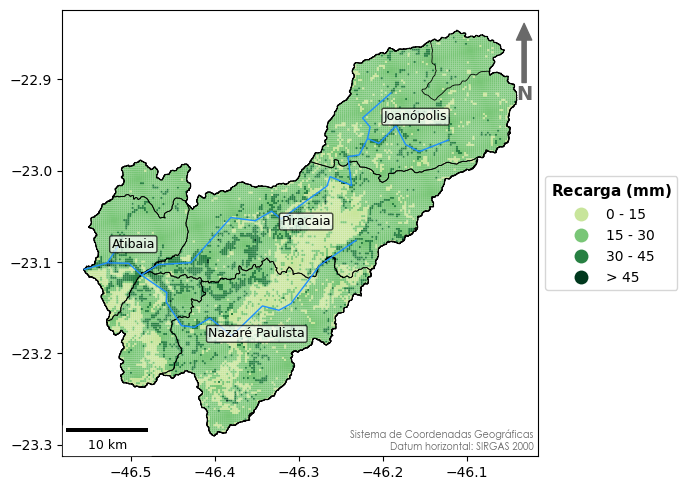

In [45]:
#Configurando a figura
fig, ax = plt.subplots(figsize=(10, 5), layout='tight')    # layout='constrained'

######################################################################
#Plotando o mapa da RECARGA DE AQUÍFERO
rch_modflow.plot(ax=ax, column='cl', cmap=cmap, legend=True, legend_kwds={'title': '$\\bf{Recarga _ (mm)}$',
                                                                            'title_fontsize': 11,
                                                                            'loc': 'center left',
                                                                            'bbox_to_anchor': (1.0, 0.5),
                                                                            'fontsize': 10,
                                                                            'fmt': '{:.1f}',
                                                                            'frameon': True}, zorder=1)

#Plotando os LIMITES DA BACIA
boundaries.boundary.plot(ax=ax, color='k', lw=0.8, ls='-', label='Limites', zorder=2)

#Plotando os LIMITES DOS MUNICÍPIOS DENTRO DA BACIA
municipios_bacia.boundary.plot(ax=ax, color='k', lw=0.6, ls='-', label='Municípios', zorder=3)

#Plotando a rede de drenagem
rede_drenagem2.plot(ax=ax, color='dodgerblue', lw=1.0, ls='-', label='Rede hidrorgráfica', zorder=3)

#Plotando os LABELS dos municípios dentro da bacia
muni_selecionados.apply(lambda x: ax.annotate(text=x['NM_MUN'], xy=x.geometry.centroid.coords[0], fontsize=9, ha='center', va='center', bbox=dict(boxstyle='round, pad=0.15', facecolor='white', alpha=0.7)), axis=1)

#Título da figura (superior)
# fig.suptitle('Mapa de recarga', fontsize=14, color='k', weight='bold')

#Seta do Norte
x, y, arrow_length = 0.97, 0.97, 0.16
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='dimgray', edgecolor='dimgray', width=3, headwidth=11),
            ha='center', va='center', fontsize=14, color='dimgray', weight='bold',
            xycoords=ax.transAxes)

#Escala cartográfica
scalebar = ScaleBar(distance_meters, location='lower left', font_properties={'size': 9})
ax.add_artist(scalebar)

#Textos no mapa
plt.text(0.99, 0.01, 'Sistema de Coordenadas Geográficas\nDatum horizontal: SIRGAS 2000', transform=ax.transAxes, va='bottom', ha='right', color='k', fontsize=7, fontweight='light', fontname='Century Gothic', alpha=0.6)
# plt.text(0.5, 0.01, 'Sistema de Coordenadas Geográficas\nDatum horizontal: SIRGAS 2000', transform=ax.transAxes, va='bottom', ha='center', color='k', fontsize=7, fontweight='light', fontname='Century Gothic', alpha=0.6)

# plt.text(0.99, 0.09, 'Elaborado por\nWander Araújo Martins', transform=ax.transAxes, va='bottom', ha='right', color='k', fontsize=7, fontweight='light', fontname='Century Gothic', alpha=0.6)
# plt.text(0.5, 0.09, 'Elaborado por\nWander Araújo Martins', transform=ax.transAxes, va='bottom', ha='center', color='k', fontsize=7, fontweight='light', fontname='Century Gothic', alpha=0.6)


##################################################
#Anotações de sub-bacia Jundiaí-Mirim e Serra do Japi no mapa

# arrowprops = dict(arrowstyle='->', color='k', lw=0.7, ls='--')
# color, size, fontweight, fontname, alpha = 'k', 10, 'light', 'Century Gothic', 1.0

# ax.annotate(text='Sub-bacia\nJundiaí-Mirim', xy=(0.65, 0.7), xytext=(0.65, 0.92), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
# ax.annotate(text='Serra do\nJapi', xy=(0.48, 0.33), xytext=(0.55, 0.08), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
##################################################

#Salvando o mapa --> Tese
plt.savefig(results_path + 'mapa_rec_modflow_cm.png', facecolor='w', bbox_inches='tight', dpi=300)

#Salvando o mapa --> App
# plt.savefig('C:/app_vazao/pages/recharge_maps/rch_map_' + f'{bacia}' + '.png', facecolor='w', bbox_inches='tight', dpi=300)

#Visualizando o mapa
plt.show()

In [46]:
rch_modflow['mean'].describe()

count    18737.000000
mean        20.822930
std          8.136115
min          0.000000
25%         16.342904
50%         21.187473
75%         25.770760
max         64.945332
Name: mean, dtype: float64

#### Gráfico donuts de classes de recarga

In [47]:
a = 1000000
b = 10 ** 6

print(b)

1000000


In [48]:
#Calculando a área em km^2 de recarga para cada classe
area_km2_rec_class1 = ((len(rch_modflow.loc[(rch_modflow['mean'] > 0) & (rch_modflow['mean'] < 15)])) * (250 * 250) / 10 ** 6)
area_km2_rec_class2 = ((len(rch_modflow.loc[(rch_modflow['mean'] > 15) & (rch_modflow['mean'] < 30)])) * (250 * 250) / 10 ** 6)
area_km2_rec_class3 = ((len(rch_modflow.loc[(rch_modflow['mean'] > 30) & (rch_modflow['mean'] < 45)])) * (250 * 250) / 10 ** 6)
area_km2_rec_class4 = ((len(rch_modflow.loc[(rch_modflow['mean'] > 45) & (rch_modflow['mean'] < 10000)])) * (250 * 250) / 10 ** 6)

#Criando uma lista vazia para posteriormente adicionar cada valor de área de recarga
lista_areas_rec2 = []
lista_areas_rec2.append(area_km2_rec_class1)
lista_areas_rec2.append(area_km2_rec_class2)
lista_areas_rec2.append(area_km2_rec_class3)
lista_areas_rec2.append(area_km2_rec_class4)

for area_rec in lista_areas_rec2:
    print(f'{round(area_rec, 1)} km^2')

197.9 km^2
817.3 km^2
128.8 km^2
1.5 km^2


In [49]:
#Calculando a área em km^2 de recarga para cada classe
area_km2_rec_classe1 = ((len(rch_modflow.loc[(rch_modflow['mean'] > 0) & (rch_modflow['mean'] < 15)])) * (250 * 250) / 10 ** 6)
area_km2_rec_classe2 = ((len(rch_modflow.loc[(rch_modflow['mean'] > 15) & (rch_modflow['mean'] < 30)])) * (250 * 250) / 10 ** 6)
area_km2_rec_classe3 = ((len(rch_modflow.loc[(rch_modflow['mean'] > 30) & (rch_modflow['mean'] < 45)])) * (250 * 250) / 10 ** 6)
area_km2_rec_classe4 = ((len(rch_modflow.loc[(rch_modflow['mean'] > 45) & (rch_modflow['mean'] < 10000)])) * (250 * 250) / 10 ** 6)

#Criando uma lista vazia para posteriormente adicionar cada valor de área de recarga
lista_areas_rec = []
lista_areas_rec.append(area_km2_rec_classe1)
lista_areas_rec.append(area_km2_rec_classe2)
lista_areas_rec.append(area_km2_rec_classe3)
lista_areas_rec.append(area_km2_rec_classe4)

#Criando os rótulos que aparecerão no plot e suas respectivas cores
labels_rec = ['0 - 15 mm', '15 - 30 mm', '30 - 45 mm', '> 45 mm']
cores_rec = ['#c8e59b', '#79c677', '#278042', '#00381d']

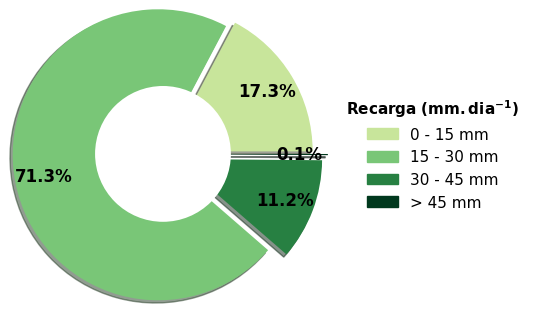

In [50]:
cm = 1/2.54
plt.figure(figsize=(8*cm, 8*cm))

explode = (0.05, 0.05, 0.15, 0.2)

plt.pie(lista_areas_rec, labels=None,
        colors=cores_rec,
        autopct='%1.1f%%',
        labeldistance=1.1,
        pctdistance=0.8,
        shadow=True,
        radius=1.5,
        explode=explode,
        textprops={'fontsize': 12,
                   'fontweight': 'bold',
                   'color': 'k'})

circle = plt.Circle(xy=(0, 0), radius=0.7, facecolor='w')
plt.gca().add_artist(circle)


#Adicionando uma legenda manualmente
classe1 = mpatches.Patch(color='#c8e59b', label='0 - 15 mm')
classe2 = mpatches.Patch(color='#79c677', label='15 - 30 mm')
classe3 = mpatches.Patch(color='#278042', label='30 - 45 mm')
classe4 = mpatches.Patch(color='#00381d', label='> 45 mm')
plt.legend(handles=[classe1, classe2, classe3, classe4], title='$\\bf{Recarga _ (mm.dia^{-1})}$', title_fontsize=11, fontsize=11, frameon=False, loc='center left', bbox_to_anchor=(1.2, 0.5))


#Salvando o plot
plt.savefig(results_path + 'plot_donuts_classes_rec.png', facecolor='w', bbox_inches='tight', dpi=300)

plt.show()

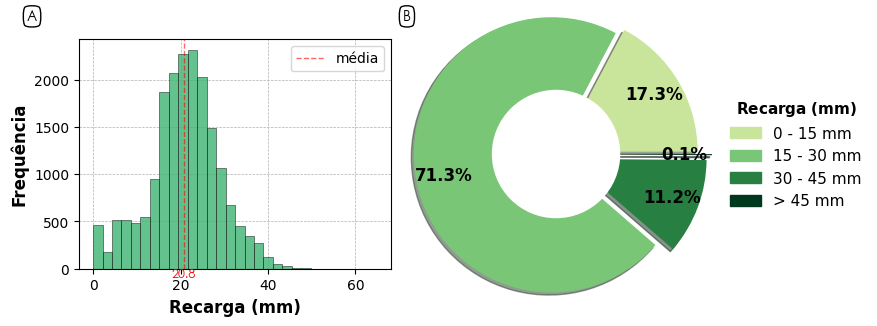

In [51]:
cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22*cm, 8*cm), layout='constrained')

############################################################
media_1 = round(rch_modflow['mean'].mean(), 1)

ax1 = rch_modflow['mean'].hist(bins=30, color='mediumseagreen', edgecolor='k', lw=0.4, alpha=0.8, zorder=2, ax=ax1)
ax1.set_xlabel('Recarga (mm)', fontsize=12, weight='bold')
ax1.set_ylabel('Frequência', fontsize=12, weight='bold')
ax1.grid(True, lw=0.5, ls='--', zorder=1)
ax1.axvline(x=media_1, color='r', lw=1.0, ls='--', alpha=0.6, label='média')
ax1.legend()

#Textos
ax1.text(media_1, -50, f'{media_1}', va='center', ha='center', color='r', fontsize=9, fontweight='light', fontname='Century Gothic')
ax1.text(-0.15, 1.1, 'A', transform=ax1.transAxes, va='center', ha='center', color='k', fontsize=10, fontweight='light', fontname='Century Gothic', bbox=dict(boxstyle='round4', facecolor='white', alpha=1.0))

############################################################
explode = (0.05, 0.05, 0.15, 0.2)

ax2.pie(lista_areas_rec,
        labels=None,
        colors=cores_rec,
        autopct='%1.1f%%',
        labeldistance=1.1,
        pctdistance=0.8,
        shadow=True,
        radius=1.5,
        explode=explode,
        textprops={'fontsize': 12,
                   'fontweight': 'bold',
                   'color': 'k'})

circle = plt.Circle(xy=(0, 0), radius=0.7, facecolor='w')
plt.gca().add_artist(circle)

#Textos
ax2.text(-0.15, 1.1, 'B', transform=ax2.transAxes, va='center', ha='center', color='k', fontsize=10, fontweight='light', fontname='Century Gothic', bbox=dict(boxstyle='round4', facecolor='white', alpha=1.0))

#Adicionando uma legenda manualmente
classe1 = mpatches.Patch(color='#c8e59b', label='0 - 15 mm')
classe2 = mpatches.Patch(color='#79c677', label='15 - 30 mm')
classe3 = mpatches.Patch(color='#278042', label='30 - 45 mm')
classe4 = mpatches.Patch(color='#00381d', label='> 45 mm')
ax2.legend(handles=[classe1, classe2, classe3, classe4], title='$\\bf{Recarga _ (mm)}$', title_fontsize=11, fontsize=11, frameon=False, loc='center left', bbox_to_anchor=(1.2, 0.5))

#Salvando o plot
plt.savefig(results_path + 'hist_donuts_rec_mod.png', facecolor='w', bbox_inches='tight', dpi=300)

plt.show()

## Mapa HRU SWAT

In [52]:
rch_swat = gpd.read_file(path + 'rch_swat.geojson')
rch_swat.head(2)

,Subbasin,LANDUSE,SOIL,SLOPE_BAND,AREA (ha),%SUBBASIN,HRUGIS,GW_RCHGmm,geometry
0,1,FRSE,RL1,0-3.0,8.0,0.006967,10001,53.870525,"MULTIPOLYGON (((382348.769 7471396.657, 382348..."
1,1,FRSE,RL1,3.0-8.0,15.0,0.013143,10002,53.121273,"MULTIPOLYGON (((382378.769 7470826.657, 382378..."


In [54]:
rch_swat = rch_swat.to_crs(epsg='4674')

In [55]:
#Limites estabelecidos
valores_hru = rch_swat['GW_RCHGmm']

quantis = mc.UserDefined(valores_hru, referencia)
cl_hru = [labels[i] for i in quantis.yb]
rch_swat = rch_swat.assign(cl_hru=cl_hru)
rch_swat.cl_hru = pd.Categorical(rch_swat.cl_hru, ordered=True, categories=labels)

In [56]:
rch_swat.head(2)

,Subbasin,LANDUSE,SOIL,SLOPE_BAND,AREA (ha),%SUBBASIN,HRUGIS,GW_RCHGmm,geometry,cl_hru
0,1,FRSE,RL1,0-3.0,8.0,0.006967,10001,53.870525,"MULTIPOLYGON (((-46.1468 -22.86112, -46.1468 -...",> 45
1,1,FRSE,RL1,3.0-8.0,15.0,0.013143,10002,53.121273,"MULTIPOLYGON (((-46.14655 -22.86627, -46.14655...",> 45


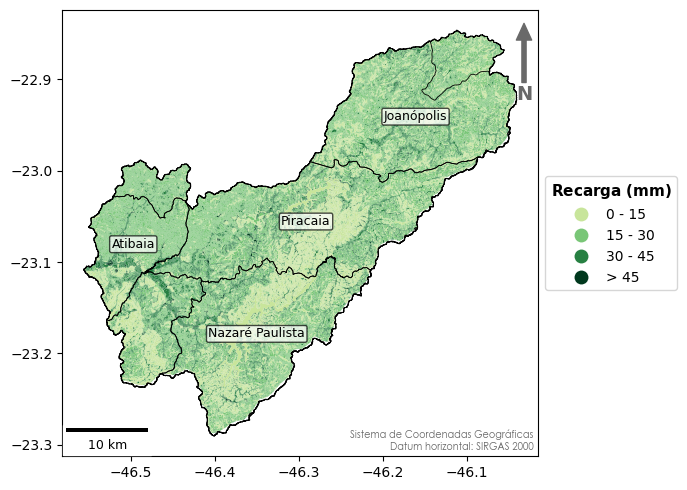

In [57]:
#Configurando a figura
fig, ax = plt.subplots(figsize=(10, 5), layout='tight')    # layout='constrained'

######################################################################
#Plotando o mapa da RECARGA DE AQUÍFERO
rch_swat.plot(ax=ax, column='cl_hru', cmap=cmap, legend=True, legend_kwds={'title': '$\\bf{Recarga _ (mm)}$',
                                                                         'title_fontsize': 11,
                                                                         'loc': 'center left',
                                                                         'bbox_to_anchor': (1.0, 0.5),
                                                                         'fontsize': 10,
                                                                         'fmt': '{:.1f}',
                                                                         'frameon': True}, zorder=1)

#Plotando os LIMITES DA BACIA
boundaries.boundary.plot(ax=ax, color='k', lw=0.8, ls='-', label='Limites', zorder=2)

#Plotando os LIMITES DOS MUNICÍPIOS DENTRO DA BACIA
municipios_bacia.boundary.plot(ax=ax, color='k', lw=0.6, ls='-', label='Municípios', zorder=3)

#Plotando os LABELS dos municípios dentro da bacia
muni_selecionados.apply(lambda x: ax.annotate(text=x['NM_MUN'], xy=x.geometry.centroid.coords[0], fontsize=9, ha='center', va='center', bbox=dict(boxstyle='round, pad=0.15', facecolor='white', alpha=0.7)), axis=1)

#Título da figura (superior)
# fig.suptitle('Mapa de recarga', fontsize=16, color='k', weight='bold')

#Seta do Norte
x, y, arrow_length = 0.97, 0.97, 0.16
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='dimgray', edgecolor='dimgray', width=3, headwidth=11),
            ha='center', va='center', fontsize=14, color='dimgray', weight='bold',
            xycoords=ax.transAxes)

#Escala cartográfica
scalebar = ScaleBar(distance_meters, location='lower left', font_properties={'size': 9})
ax.add_artist(scalebar)

#Textos no mapa
plt.text(0.99, 0.01, 'Sistema de Coordenadas Geográficas\nDatum horizontal: SIRGAS 2000', transform=ax.transAxes, va='bottom', ha='right', color='k', fontsize=7, fontweight='light', fontname='Century Gothic', alpha=0.6)
# plt.text(0.5, 0.01, 'Sistema de Coordenadas Geográficas\nDatum horizontal: SIRGAS 2000', transform=ax.transAxes, va='bottom', ha='center', color='k', fontsize=7, fontweight='light', fontname='Century Gothic', alpha=0.6)

#Salvando o mapa
plt.savefig(results_path + 'mapa_rec_swat_cm.png', facecolor='w', bbox_inches='tight', dpi=300)

#Visualizando o mapa
plt.show()

## Mapas por <font color=yellow> meses </font>

### Cópia do gdf e valores de referência

In [58]:
#Cópia do gdf (rch_modflow) para criar os gdf para cada mês
rch_months = rch_modflow.copy(deep=True)

#Removendo as colunas 'mean' e 'cl' do gdf 'rch_modflow' para não ter conflito com as criadas a partir daqui
rch_months.drop(['mean', 'cl'], axis=1, inplace=True)

### GDF para cada mês

#### Jan

In [59]:
jan = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['Jan']))]
jan = jan.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
jan['mean'] = jan.mean(axis=1)
jan = jan[['mean']]
jan = pd.concat([rch_months, jan], axis=1)
jan = jan[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_jan = jan['mean']
classdef_jan = mc.UserDefined(valores_jan, referencia)
cl_jan = [labels[i] for i in classdef_jan.yb]
jan = jan.assign(cl_jan=cl_jan)
jan.cl_jan = pd.Categorical(jan.cl_jan, ordered=True, categories=labels)

#### Feb

In [60]:
feb = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['Feb']))]
feb = feb.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
feb['mean'] = feb.mean(axis=1)
feb = feb[['mean']]
feb = pd.concat([rch_months, feb], axis=1)
feb = feb[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_feb = feb['mean']
classdef_feb = mc.UserDefined(valores_feb, referencia)
cl_feb = [labels[i] for i in classdef_feb.yb]
feb = feb.assign(cl_feb=cl_feb)
feb.cl_feb = pd.Categorical(feb.cl_feb, ordered=True, categories=labels)

#### Mar

In [61]:
mar = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['Mar']))]
mar = mar.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
mar['mean'] = mar.mean(axis=1)
mar = mar[['mean']]
mar = pd.concat([rch_months, mar], axis=1)
mar = mar[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_mar = mar['mean']
classdef_mar = mc.UserDefined(valores_mar, referencia)
cl_mar = [labels[i] for i in classdef_mar.yb]
mar = mar.assign(cl_mar=cl_mar)
mar.cl_mar = pd.Categorical(mar.cl_mar, ordered=True, categories=labels)

#### Apr

In [62]:
apr = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['Apr']))]
apr = apr.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
apr['mean'] = apr.mean(axis=1)
apr = apr[['mean']]
apr = pd.concat([rch_months, apr], axis=1)
apr = apr[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_apr = apr['mean']
classdef_apr = mc.UserDefined(valores_apr, referencia)
cl_apr = [labels[i] for i in classdef_apr.yb]
apr = apr.assign(cl_apr=cl_apr)
apr.cl_apr = pd.Categorical(apr.cl_apr, ordered=True, categories=labels)

#### May

In [63]:
may = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['May']))]
may = may.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
may['mean'] = may.mean(axis=1)
may = may[['mean']]
may = pd.concat([rch_months, may], axis=1)
may = may[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_may = may['mean']
classdef_may  = mc.UserDefined(valores_may, referencia)
cl_may = [labels[i] for i in classdef_may.yb]
may = may.assign(cl_may=cl_may)
may.cl_may = pd.Categorical(may.cl_may, ordered=True, categories=labels)

#### Jun

In [64]:
jun = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['Jun']))]
jun = jun.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
jun['mean'] = jun.mean(axis=1)
jun = jun[['mean']]
jun = pd.concat([rch_months, jun], axis=1)
jun = jun[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_jun = jun['mean']
classdef_jun = mc.UserDefined(valores_jun, referencia)
cl_jun = [labels[i] for i in classdef_jun.yb]
jun = jun.assign(cl_jun=cl_jun)
jun.cl_jun = pd.Categorical(jun.cl_jun, ordered=True, categories=labels)

#### Jul

In [65]:
jul = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['Jul']))]
jul = jul.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
jul['mean'] = jul.mean(axis=1)
jul = jul[['mean']]
jul = pd.concat([rch_months, jul], axis=1)
jul = jul[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_jul = jul['mean']
classdef_jul = mc.UserDefined(valores_jul, referencia)
cl_jul = [labels[i] for i in classdef_jul.yb]
jul = jul.assign(cl_jul=cl_jul)
jul.cl_jul = pd.Categorical(jul.cl_jul, ordered=True, categories=labels)

#### Aug

In [66]:
aug = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['Aug']))]
aug = aug.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
aug['mean'] = aug.mean(axis=1)
aug = aug[['mean']]
aug = pd.concat([rch_months, aug], axis=1)
aug = aug[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_aug = aug['mean']
classdef_aug = mc.UserDefined(valores_aug, referencia)
cl_aug = [labels[i] for i in classdef_aug.yb]
aug = aug.assign(cl_aug=cl_aug)
aug.cl_aug = pd.Categorical(aug.cl_aug, ordered=True, categories=labels)

#### Sep

In [67]:
sep = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['Sep']))]
sep = sep.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
sep['mean'] = sep.mean(axis=1)
sep = sep[['mean']]
sep = pd.concat([rch_months, sep], axis=1)
sep = sep[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_sep = sep['mean']
classdef_sep = mc.UserDefined(valores_sep, referencia)
cl_sep = [labels[i] for i in classdef_sep.yb]
sep = sep.assign(cl_sep=cl_sep)
sep.cl_sep = pd.Categorical(sep.cl_sep, ordered=True, categories=labels)

#### Oct

In [68]:
oct = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['Oct']))]
oct = oct.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
oct['mean'] = oct.mean(axis=1)
oct = oct[['mean']]
oct = pd.concat([rch_months, oct], axis=1)
oct = oct[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_oct = oct['mean']
classdef_oct = mc.UserDefined(valores_oct, referencia)
cl_oct= [labels[i] for i in classdef_oct.yb]
oct = oct.assign(cl_oct= cl_oct)
oct.cl_oct = pd.Categorical(oct.cl_oct, ordered=True, categories=labels)

#### Nov

In [69]:
nov = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['Nov']))]
nov = nov.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
nov['mean'] = nov.mean(axis=1)
nov = nov[['mean']]
nov = pd.concat([rch_months, nov], axis=1)
nov = nov[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_nov = nov['mean']
classdef_nov = mc.UserDefined(valores_nov , referencia)
cl_nov  = [labels[i] for i in classdef_nov.yb]
nov = nov.assign(cl_nov =cl_nov )
nov.cl_nov  = pd.Categorical(nov.cl_nov , ordered=True, categories=labels)

#### Dec

In [70]:
dec = rch_months.iloc[:, rch_months.columns.str.startswith(tuple(['Dec']))]
dec = dec.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
dec['mean'] = dec.mean(axis=1)
dec = dec[['mean']]
dec = pd.concat([rch_months, dec], axis=1)
dec = dec[['fid', 'mean', 'geometry']]

#Limites estabelecidos
valores_dec = dec['mean']
classdef_dec = mc.UserDefined(valores_dec, referencia)
cl_dec = [labels[i] for i in classdef_dec.yb]
dec = dec.assign(cl_dec=cl_dec)
dec.cl_dec = pd.Categorical(dec.cl_dec, ordered=True, categories=labels)

### <font color=yellow> Mapa </font>

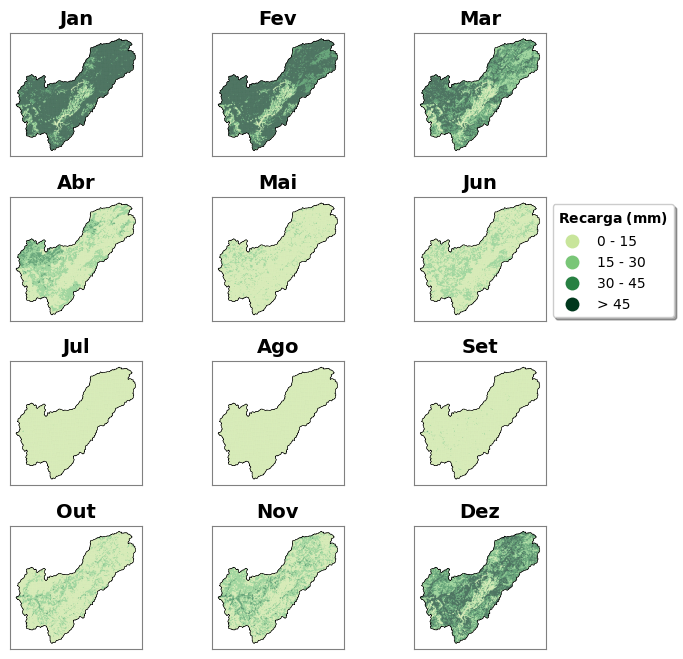

In [71]:
"""
Formas de controlar a cor das linhas do frame (spines):

Modo1: aplica a todos os spines
ax1.spines[:].set_color('red')

Modo2: aplica a spines específicos por meio de uma lista
ax1.spines[['top', 'right']].set_color('red')


Para remover todo o frame:
ax1.set_axis_off()

"""


#Configurando a página
cm = 1/2.54
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(nrows=4, ncols=3, sharex=False, sharey=False, layout='tight', figsize=(40*cm, 17*cm))    # layout='constrained'    'tight'

fontsize = 14
left, bottom, labelleft, labelbottom = False, False, False, False
cor_spines = 'gray'


######################################################################
jan.plot(ax=ax1, column='cl_jan', cmap=cmap)
boundaries.boundary.plot(ax=ax1, color='k', lw=0.4, zorder=2)
ax1.set_title('Jan', fontsize=fontsize, color='k', weight='bold')
ax1.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax1.spines[:].set_color(cor_spines)


feb.plot(ax=ax2, column='cl_feb', cmap=cmap)
boundaries.boundary.plot(ax=ax2, color='k', lw=0.4, zorder=2)
ax2.set_title('Fev', fontsize=fontsize, color='k', weight='bold')
ax2.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax2.spines[:].set_color(cor_spines)


mar.plot(ax=ax3, column='cl_mar', cmap=cmap)
boundaries.boundary.plot(ax=ax3, color='k', lw=0.4, zorder=2)
ax3.set_title('Mar', fontsize=fontsize, color='k', weight='bold')
ax3.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax3.spines[:].set_color(cor_spines)


apr.plot(ax=ax4, column='cl_apr', cmap=cmap)
boundaries.boundary.plot(ax=ax4, color='k', lw=0.4, zorder=2)
ax4.set_title('Abr', fontsize=fontsize, color='k', weight='bold')
ax4.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax4.spines[:].set_color(cor_spines)


may.plot(ax=ax5, column='cl_may', cmap=cmap)
boundaries.boundary.plot(ax=ax5, color='k', lw=0.4, zorder=2)
ax5.set_title('Mai', fontsize=fontsize, color='k', weight='bold')
ax5.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax5.spines[:].set_color(cor_spines)


jun.plot(ax=ax6, column='cl_jun', cmap=cmap, legend=True, legend_kwds={'title': '$\\bf{Recarga _ (mm)}$',
                                                                   'title_fontsize': 10,
                                                                   'ncols': 1,
                                                                   'loc': 'upper left',
                                                                   'bbox_to_anchor': (1.0, 1.0),
                                                                   'fontsize': 10,
                                                                   'fmt': '{:.1f}',
                                                                   'frameon': True,
                                                                   'alignment': 'left',
                                                                   'shadow': True})
boundaries.boundary.plot(ax=ax6, color='k', lw=0.4, zorder=2)
ax6.set_title('Jun', fontsize=fontsize, color='k', weight='bold')
ax6.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax6.spines[:].set_color(cor_spines)


jul.plot(ax=ax7, column='cl_jul', cmap=cmap)
boundaries.boundary.plot(ax=ax7, color='k', lw=0.4, zorder=2)
ax7.set_title('Jul', fontsize=fontsize, color='k', weight='bold')
ax7.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax7.spines[:].set_color(cor_spines)


aug.plot(ax=ax8, column='cl_aug', cmap=cmap)
boundaries.boundary.plot(ax=ax8, color='k', lw=0.4, zorder=2)
ax8.set_title('Ago', fontsize=fontsize, color='k', weight='bold')
ax8.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax8.spines[:].set_color(cor_spines)


sep.plot(ax=ax9, column='cl_sep', cmap=cmap)
boundaries.boundary.plot(ax=ax9, color='k', lw=0.4, zorder=2)
ax9.set_title('Set', fontsize=fontsize, color='k', weight='bold')
ax9.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax9.spines[:].set_color(cor_spines)


oct.plot(ax=ax10, column='cl_oct', cmap=cmap)
boundaries.boundary.plot(ax=ax10, color='k', lw=0.4, zorder=2)
ax10.set_title('Out', fontsize=fontsize, color='k', weight='bold')
ax10.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax10.spines[:].set_color(cor_spines)


nov.plot(ax=ax11, column='cl_nov', cmap=cmap)
boundaries.boundary.plot(ax=ax11, color='k', lw=0.4, zorder=2)
ax11.set_title('Nov', fontsize=fontsize, color='k', weight='bold')
ax11.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax11.spines[:].set_color(cor_spines)


dec.plot(ax=ax12, column='cl_dec', cmap=cmap)
boundaries.boundary.plot(ax=ax12, color='k', lw=0.4, zorder=2)
ax12.set_title('Dez', fontsize=fontsize, color='k', weight='bold')
ax12.tick_params(left=left, bottom=bottom, labelleft=labelleft, labelbottom=labelbottom)
ax12.spines[:].set_color(cor_spines)


#Título superior
# plt.suptitle(f'Sub-bacia {bacia.upper()}', x=0.5, y=1.0, fontsize=12, color='k', weight='bold')    # , bbox={'facecolor': 'gray', 'alpha': 0.9, 'pad': 5}

#Talvez ajustar a distância entre os subplots usando essa função do plt
# plt.subplots_adjust(wspace=0.1, hspace=0.1)

#Ajuste dos espaços entre colunas e linhas de subplots --> modo Lucas
# fig.tight_layout(pad=0.4, w_pad=-5, h_pad=0.5)
fig.tight_layout(w_pad=-10)


#Salvando a figura
plt.savefig(results_path + 'mapa_rec_modflow_mes_mes.png', facecolor='w', bbox_inches='tight', dpi=300)

#Visualizando a figura
plt.show()

In [72]:
# lista_dfs_meses = [jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec]

# for num, mes in enumerate(lista_dfs_meses):
#     print(f'{num + 1}\n{mes['mean'].describe()}')

## Conversão de dados

### Dados de recarga do modelo <font color=yellow> SWAT </font>

In [73]:
rch_hru_swat = pd.read_excel(path + 'hru.xlsx')
df_cultanual = rch_hru_swat.copy(deep=True)

In [74]:
rch_hru_swat

,LULC,HRU,HRUGIS,SUB,YEAR,MON,AREAkm2,GW_RCHGmm,YYYYMM
0,FRSE,1,10001,1,1985,1,0.080140,72.819,198501
1,FRSE,2,10002,1,1985,1,0.151300,71.812,198501
2,FRSE,3,10003,1,1985,1,0.868350,66.293,198501
3,FRSE,4,10004,1,1985,1,8.437900,41.636,198501
4,FRSE,5,10005,1,1985,1,10.282000,30.616,198501
...,...,...,...,...,...,...,...,...,...
236299,ORCD,543,10543,1,2020,12,0.000909,0.438,202012
236300,ORCD,544,10544,1,2020,12,0.000909,0.623,202012
236301,ORCD,545,10545,1,2020,12,0.003638,8.931,202012
236302,ORCD,546,10546,1,2020,12,0.006366,5.753,202012


In [75]:
#Obtendo o primeiro e último ano do período
ano_inicial = rch_hru_swat.loc[0, 'YEAR'].astype('str')
ano_final = rch_hru_swat.iloc[-1, 4].astype('str')

#Tabela dinâmica, criando coluna de data, selecionando somente rec e renomeando
rch_hru_swat = pd.pivot_table(rch_hru_swat, index=['YEAR', 'MON'], values=['GW_RCHGmm'], aggfunc='mean', sort=False)
rch_hru_swat['Date'] = pd.date_range(start='01/01/' + ano_inicial, end='12/31/' + ano_final, freq='MS')
rch_hru_swat.reset_index(['YEAR', 'MON'], inplace=True)
cols = ['Date', 'GW_RCHGmm']
rch_hru_swat = rch_hru_swat[cols]
rch_hru_swat.rename(columns={'GW_RCHGmm': 'rch_swat'}, inplace=True)

#Exportando o df como planilha .csv
rch_hru_swat.to_csv(results_path + '1_planilha_rch_hru_swat.csv', index=False)

rch_hru_swat

,Date,rch_swat
0,1985-01-01,32.663410
1,1985-02-01,29.333265
2,1985-03-01,37.029444
3,1985-04-01,35.525552
4,1985-05-01,31.003814
...,...,...
427,2020-08-01,14.962419
428,2020-09-01,12.193587
429,2020-10-01,10.799592
430,2020-11-01,9.137700


In [76]:
df_ano = rch_hru_swat.copy(deep=True)
df_ano.set_index('Date', inplace=True)

ano_min = df_ano.index.min().year
ano_max = df_ano.index.max().year
periodo = (ano_max - ano_min) + 1

print(f'De {ano_min} até {ano_max} | {periodo} ano(s)')

De 1985 até 2020 | 36 ano(s)


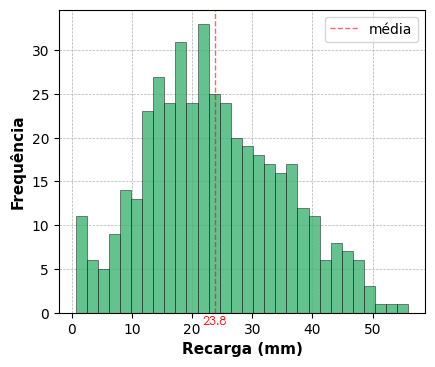

In [77]:
#Configurando a figura em centímetros
cm = 1/2.54
plt.figure(figsize=(12*cm, 10*cm))


media_2 = round(rch_hru_swat['rch_swat'].mean(), 1)

rch_hru_swat['rch_swat'].hist(bins=30, color='mediumseagreen', edgecolor='k', lw=0.4, alpha=0.8, zorder=2)
# plt.title(f'Histograma de recarga do modelo SWAT ({bacia.upper()})', fontsize=11, fontweight='bold')
plt.xlabel('Recarga (mm)', fontsize=11, weight='bold')
plt.ylabel('Frequência', fontsize=11, weight='bold')
plt.grid(True, lw=0.5, ls='--', zorder=1)
plt.axvline(x=media_2, color='r', lw=1.0, ls='--', alpha=0.6, label='média')
plt.text(media_2, -1, f'{media_2}', va='center', ha='center', color='r', fontsize=9, fontweight='light', fontname='Century Gothic')
plt.legend()

plt.savefig(results_path + 'hist_rec_swat.png', facecolor='w', bbox_inches='tight', dpi=300)

plt.show()

In [78]:
rch_hru_swat.describe(exclude=['datetime64[ns]'])

,rch_swat
count,432.000000
mean,23.750036
std,11.393485
min,0.627817
25%,15.421452
50%,22.313754
75%,31.881065
max,55.959278


In [79]:
rch_annually = rch_hru_swat.copy(deep=True)
rch_annually.set_index('Date', inplace=True)
rch_annually = rch_annually.resample('YE').sum()

#Exportando o df como planilha .csv
rch_annually.to_csv(results_path + '2_planilha_rch_annually.csv', index=True)

rch_annually

,rch_swat
Date,
1985-12-31,281.714951
1986-12-31,246.713508
1987-12-31,404.006603
1988-12-31,413.661219
1989-12-31,310.510576
1990-12-31,346.318718
1991-12-31,345.592954
1992-12-31,248.552238
1993-12-31,415.151782


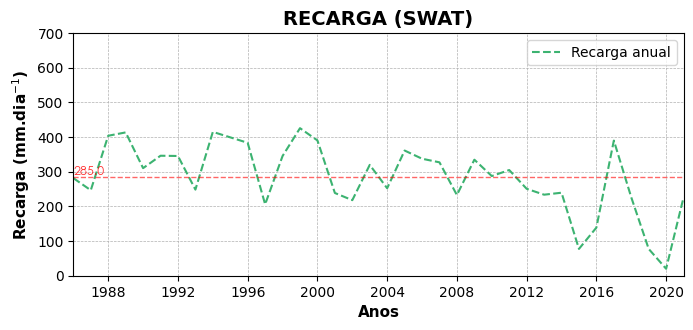

In [80]:
#Visualização da recarga anual

#Configurando a figura em centímetros
cm = 1/2.54
plt.figure(figsize=(20*cm, 8*cm))

#Plotando a recarga (linha) e configurando rótulos dos eixos, limites e gride
plt.plot(rch_annually.index, rch_annually['rch_swat'], color='mediumseagreen', lw=1.5, ls='--', label='Recarga anual')
plt.ylabel('Recarga (mm.dia$^{-1}$)', fontsize=11, weight='bold')
plt.xlabel('Anos', fontsize=11, weight='bold')
plt.ylim(0, 700)    # rch_annually['rch_swat'].max()*1.2
plt.xlim(rch_annually.index.min(), rch_annually.index.max())
plt.legend()
plt.grid(True, lw=0.5, ls='--')
plt.title('RECARGA (SWAT)', fontsize=14, weight='bold')

#Configurando a média e a linha que representa a média
m = rch_annually['rch_swat'].mean().round(1)
plt.axhline(y=m, color='r', lw=1.0, ls='--', alpha=0.6, label='média')
plt.text(rch_annually.index.min(), m, f'{m}', va='bottom', ha='left', color='r', fontsize=9, fontweight='light', alpha=0.8, fontname='Century Gothic')


#Salvando o gráfico
plt.savefig(results_path + 'plot_rec_swat_anual.png', facecolor='w', bbox_inches='tight', dpi=300)

#Visualizando
plt.show()

#### Agregação das classes agrícolas em "Cultura anual" para elaborar o plot de rec por uso

In [81]:
df_cultanual

,LULC,HRU,HRUGIS,SUB,YEAR,MON,AREAkm2,GW_RCHGmm,YYYYMM
0,FRSE,1,10001,1,1985,1,0.080140,72.819,198501
1,FRSE,2,10002,1,1985,1,0.151300,71.812,198501
2,FRSE,3,10003,1,1985,1,0.868350,66.293,198501
3,FRSE,4,10004,1,1985,1,8.437900,41.636,198501
4,FRSE,5,10005,1,1985,1,10.282000,30.616,198501
...,...,...,...,...,...,...,...,...,...
236299,ORCD,543,10543,1,2020,12,0.000909,0.438,202012
236300,ORCD,544,10544,1,2020,12,0.000909,0.623,202012
236301,ORCD,545,10545,1,2020,12,0.003638,8.931,202012
236302,ORCD,546,10546,1,2020,12,0.006366,5.753,202012


In [82]:
#Obtendo as classes de uso existentes na coluna LULC do df
df_cultanual['LULC'].unique()

array(['FRSE', 'EUCA', 'WETL', 'PAST', 'SUGC', 'AGRL', 'RICE', 'BSVG',
       'VRAS', 'WATR', 'SOYB', 'CORN', 'COFF', 'ORCD'], dtype=object)

In [83]:
df_cultanual.replace(["SOYB", "CORN", "AGRL", "RICE"], 'Culturas anuais', inplace=True)
df_cultanual.replace(["ORAN", 'ORCD'], 'Culturas perenes', inplace=True)

In [84]:
#Usando o Groupby do pandas para agrupar os valores de rec para cada uso
tabela_grouped = df_cultanual.groupby('LULC')[['GW_RCHGmm']].mean().sort_values(by=['GW_RCHGmm'], ascending=False)

tabela_grouped

,GW_RCHGmm
LULC,
WETL,38.159149
BSVG,37.894624
PAST,32.448968
SUGC,28.740820
FRSE,27.170279
Culturas anuais,24.902458
VRAS,22.015428
COFF,21.444418
EUCA,20.384715


In [85]:
#Removendo a classe "WATR" (Água) do df através do método drop do pandas

tabela_grouped.drop('WATR', axis=0, inplace=True)

In [86]:
tabela_grouped.reset_index('LULC', inplace=True)

dicionario_usos = {'WETL' : 'Várzea',
                   'FRSE' : 'Mata nativa',
                   'PAST': 'Pastagem',
                   'SUGC': 'Cana-de-açúcar',
                   'EUCA': 'Reflorestamento',
                   'COFF': 'Café',
                   'BSVG': 'Solo exposto',
                   'VRAS': 'Vegetação rasteira',
                   'VARB': 'Vegetação arbustiva',
                   'RNGB': 'Macega'}

tabela_grouped.replace(dicionario_usos, inplace=True)

tabela_grouped.set_index('LULC', inplace=True)

tabela_grouped.sort_values(by=['GW_RCHGmm'], ascending=True, inplace=True)

tabela_grouped

,GW_RCHGmm
LULC,
Culturas perenes,12.316674
Reflorestamento,20.384715
Café,21.444418
Vegetação rasteira,22.015428
Culturas anuais,24.902458
Mata nativa,27.170279
Cana-de-açúcar,28.740820
Pastagem,32.448968
Solo exposto,37.894624


In [87]:
#Obtendo o máximo valor de recarga, arredondando para cima (int mais próximo), adicionando 15% ao valor original
maxima_recarga = tabela_grouped['GW_RCHGmm'].max()
maxima_recarga = math.ceil(maxima_recarga)
maxima_recarga = maxima_recarga + (maxima_recarga * 0.15)

print(f'O valor obtido desse processo é {maxima_recarga} mm')

O valor obtido desse processo é 44.85 mm


In [88]:
#Verificando a média da recarga simulada pelo modelo SWAT

media_plot_usos = round(rch_hru_swat['rch_swat'].mean(), 1)
media_plot_usos = media_plot_usos.astype(int)

print(type(media_plot_usos))
print(f'Média da recarga: {media_plot_usos} mm')

<class 'numpy.int64'>
Média da recarga: 23 mm


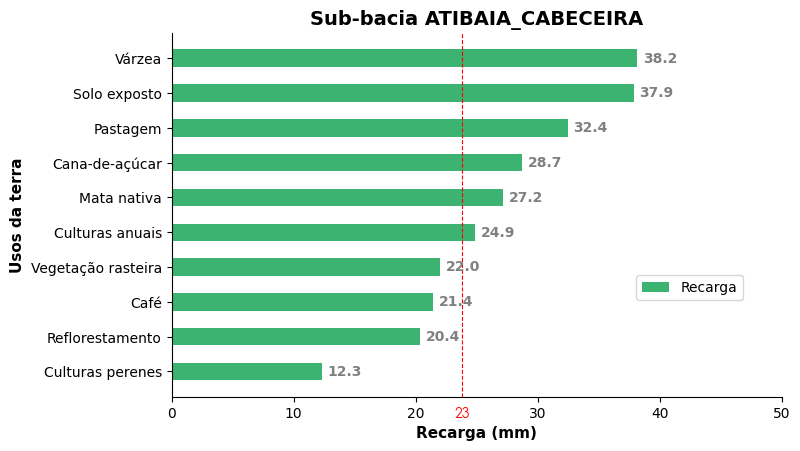

In [89]:
#Configurando a figura em centímetros
cm = 1/2.54
plt.figure(figsize=(20*cm, 12*cm))

plot1 = plt.barh(tabela_grouped.index, tabela_grouped['GW_RCHGmm'], color='mediumseagreen', height=0.5, label='Recarga')

plt.xlabel('Recarga (mm)', fontsize=11, weight='bold')
plt.ylabel('Usos da terra', fontsize=11, weight='bold')
plt.xlim(0, 50)    # maxima_recarga
plt.legend(loc='center left', bbox_to_anchor=(0.75, 0.3))
plt.bar_label(plot1, color='gray', fontsize=10, weight='bold', label_type='edge', padding=4, fmt='%.01f')
plt.axvline(x=media_2, color='r', lw=0.8, ls='--')
plt.text(media_2, -1.2, f'{media_plot_usos}', va='center', ha='center', color='r', fontsize=10, fontweight='light', fontname='Century Gothic')
plt.title(f'Sub-bacia {bacia.upper()}', color='k', fontsize=14, weight='bold')

sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.savefig(results_path + 'plot_rec_swat_por_uso.png', facecolor='w', bbox_inches='tight', dpi=300)

plt.show()

## Dados de recarga do modelo <font color=yellow> MODFLOW </font>

* Ver este [link](https://www.ldeo.columbia.edu/~martins/hydro/case_studies/units_dimensions.html#:~:text=%5BL%20T%2D1%5D,meter%20per%20second) para entender sobre simbologia LT<sup>-1</sup>
* Consultar esta [documentação](https://water.usgs.gov/ogw/modflow/mf6io_6.0.3.pdf) (p. 81 do pdf) para entender sobre a unidade de saída da recarga do modelo --> "This rate is multiplied inside the program by the surface area of the cell to calculate the volumetric recharge rate."
* Ver este [link](https://www.researchgate.net/post/Easy_Method_for_Groundwater_Recharge_Calculation) para dica sobre método de estimar a recarga com dados de nível de lençol freático.

In [90]:
#Cópia do gdf de recarga do MODFLOW para analisar os dados de recarga por meio de média de toda a bacia
rch_cell_mod = rch_modflow.copy(deep=True)

#Selecionando somente as colunas com dados de recarga
rch_cell_mod = rch_cell_mod.loc[:, 'Jan-1985': 'Dec-2020']    # --> Período selecionado de 'Jan-1985': 'Dec-2020', pois este é o período do modelo SWAT

#Obtendo a média de todas as células do grid (média ao longo das linhas (axis=0))
rch_cell_mod.loc['mean'] = rch_cell_mod.mean(axis=0)

rch_cell_mod

,Jan-1985,Feb-1985,Mar-1985,Apr-1985,May-1985,Jun-1985,Jul-1985,Aug-1985,Sep-1985,Oct-1985,...,Mar-2020,Apr-2020,May-2020,Jun-2020,Jul-2020,Aug-2020,Sep-2020,Oct-2020,Nov-2020,Dec-2020
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18733,127.980000,20.078800,119.517000,22.586500,0.528130,0.011580,0.000270,0.000010,0.000000,0.000000,...,148.930000,3.358630,0.078510,0.001670,0.000040,0.000000,0.000000,0.000000,0.000000,1.020270
18734,133.438000,47.118900,146.049000,0.567390,0.000000,0.339170,0.000000,0.000000,0.000000,0.000000,...,30.171700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.028800
18735,140.694000,37.655500,163.769000,1.139090,0.000000,2.124420,0.000000,0.000000,0.000000,0.000000,...,46.843800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.743970
18736,221.045000,76.142100,172.135000,82.487900,13.641700,4.295050,0.870930,0.138440,0.022480,0.003710,...,303.752000,49.783300,8.221440,1.306900,0.212190,0.035040,0.005690,0.000940,0.000150,0.450640


In [91]:
#Mantendo somente a linha de médias de todas as células e excluindo as demais
rch_cell_mod = rch_cell_mod.filter(items=['mean'], axis=0)

rch_cell_mod

,Jan-1985,Feb-1985,Mar-1985,Apr-1985,May-1985,Jun-1985,Jul-1985,Aug-1985,Sep-1985,Oct-1985,...,Mar-2020,Apr-2020,May-2020,Jun-2020,Jul-2020,Aug-2020,Sep-2020,Oct-2020,Nov-2020,Dec-2020
mean,127.007046,48.893539,124.545128,24.798354,3.600981,6.720869,0.698327,0.101367,0.486706,0.356911,...,68.185706,5.059727,0.352976,0.335324,0.067216,0.736706,0.132398,1.158683,0.685301,16.550461


In [92]:
rch_cell_mod = rch_cell_mod.T
rch_cell_mod.head()

,mean
Jan-1985,127.007046
Feb-1985,48.893539
Mar-1985,124.545128
Apr-1985,24.798354
May-1985,3.600981


In [93]:
#Renomeando a coluna de recarga e resetando o índice
rch_cell_mod.rename(columns={'mean': 'rch_modflow (m^3/dia)'}, inplace=True)
rch_cell_mod.reset_index(inplace=True, drop=True)

#Criando a coluna de datas --> escala mensal
rch_cell_mod['Date'] = pd.date_range(start='01/01/1985', end='12/31/2020', freq='MS')    # --> verificar essas datas aqui...

#Selecionando as colunas de interesse
colunas = ['Date', 'rch_modflow (m^3/dia)']
rch_cell_mod = rch_cell_mod[colunas]

#Exportando o df como planilha .csv
# rch_cell_mod.to_csv(results_path + '3_planilha_rch_cell_mod.csv', index=False)

rch_cell_mod

,Date,rch_modflow (m^3/dia)
0,1985-01-01,127.007046
1,1985-02-01,48.893539
2,1985-03-01,124.545128
3,1985-04-01,24.798354
4,1985-05-01,3.600981
...,...,...
427,2020-08-01,0.736706
428,2020-09-01,0.132398
429,2020-10-01,1.158683
430,2020-11-01,0.685301


In [94]:
#Conversão da recarga de m^3/dia para mm/dia
rch_cell_mod['rch_modflow (mm/dia)'] = rch_cell_mod.apply((lambda x: (x['rch_modflow (m^3/dia)'] / 62500) * (1000 * 30.42)), axis=1)

#Selecionando apenas as colunas ['Date', 'rch_modflow (mm/dia)']
colunas_mod = ['Date', 'rch_modflow (mm/dia)']
rch_cell_mod = rch_cell_mod[colunas_mod]

#Exportando o df como .csv
rch_cell_mod.to_csv(path + 'serie_temp_mod.csv', index=False)


rch_cell_mod

,Date,rch_modflow (mm/dia)
0,1985-01-01,61.816869
1,1985-02-01,23.797463
2,1985-03-01,60.618605
3,1985-04-01,12.069855
4,1985-05-01,1.752670
...,...,...
427,2020-08-01,0.358570
428,2020-09-01,0.064441
429,2020-10-01,0.563954
430,2020-11-01,0.333550


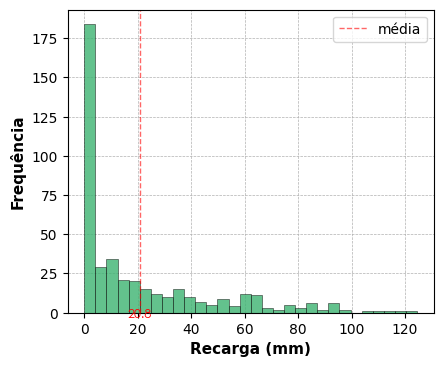

In [95]:
#Configurando a figura em centímetros
cm = 1/2.54
plt.figure(figsize=(12*cm, 10*cm))


media_3 = round(rch_cell_mod['rch_modflow (mm/dia)'].mean(), 1)

rch_cell_mod['rch_modflow (mm/dia)'].hist(bins=30, color='mediumseagreen', edgecolor='k', lw=0.4, alpha=0.8, zorder=2)
# plt.title(f'Histograma de recarga do modelo SWAT ({bacia.upper()})', fontsize=11, fontweight='bold')
plt.xlabel('Recarga (mm)', fontsize=11, weight='bold')
plt.ylabel('Frequência', fontsize=11, weight='bold')
plt.grid(True, lw=0.5, ls='--', zorder=1)
plt.axvline(x=media_3, color='r', lw=1.0, ls='--', alpha=0.6, label='média')
plt.text(media_3, -1, f'{media_3}', va='center', ha='center', color='r', fontsize=9, fontweight='light', fontname='Century Gothic')
plt.legend()

plt.savefig(results_path + 'hist_rec_mod_media_bacia.png', facecolor='w', bbox_inches='tight', dpi=300)

plt.show()

In [96]:
rch_annually_mod = rch_cell_mod.copy(deep=True)
rch_annually_mod.set_index('Date', inplace=True)
rch_annually_mod = rch_annually_mod.resample('YE').sum()

#Exportando o df como planilha .csv
rch_annually_mod.to_csv(results_path + '4_planilha_rch_annually_mod.csv', index=True)

rch_annually_mod

,rch_modflow (mm/dia)
Date,
1985-12-31,183.401521
1986-12-31,322.946636
1987-12-31,307.332727
1988-12-31,369.326935
1989-12-31,291.632572
1990-12-31,290.256737
1991-12-31,308.403126
1992-12-31,276.177524
1993-12-31,374.323057


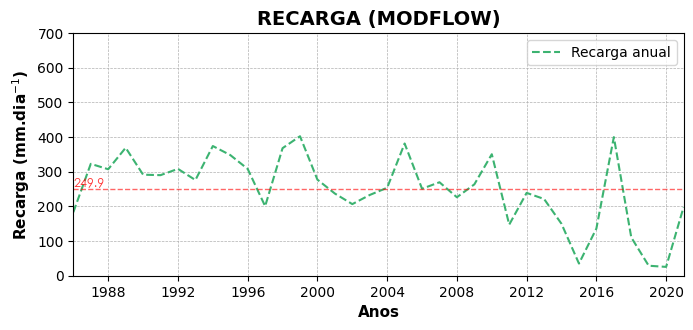

In [97]:
#Configurando a figura em centímetros
cm = 1/2.54
plt.figure(figsize=(20*cm, 8*cm))

plt.plot(rch_annually_mod.index, rch_annually_mod['rch_modflow (mm/dia)'], color='mediumseagreen', lw=1.5, ls='--', label='Recarga anual')
plt.ylabel('Recarga (mm.dia$^{-1}$)', fontsize=11, weight='bold')
plt.xlabel('Anos', fontsize=11, weight='bold')
plt.ylim(0, 700)    # rch_annually_mod['rch_modflow (mm/dia)'].max()*1.2
plt.xlim(rch_annually_mod.index.min(), rch_annually_mod.index.max())
plt.legend()
plt.grid(True, lw=0.5, ls='--')
plt.title('RECARGA (MODFLOW)', fontsize=14, weight='bold')

#Configurando a média e a linha que representa a média
m2 = rch_annually_mod['rch_modflow (mm/dia)'].mean().round(1)
plt.axhline(y=m2, color='r', lw=1.0, ls='--', alpha=0.6, label='média')
plt.text(rch_annually_mod.index.min(), m2, f'{m2}', va='bottom', ha='left', color='r', fontsize=9, fontweight='light', alpha=0.8, fontname='Century Gothic')


plt.savefig(results_path + 'plot_rec_modflow_anual_convertido.png', facecolor='w', bbox_inches='tight', dpi=300)

plt.show()

In [98]:
rch_cell_mod.describe(exclude='datetime64[ns]')

,rch_modflow (mm/dia)
count,432.000000
mean,20.822930
std,27.062220
min,0.001945
25%,0.764143
50%,8.898066
75%,32.949168
max,124.530793


In [99]:
rch_annually_mod

,rch_modflow (mm/dia)
Date,
1985-12-31,183.401521
1986-12-31,322.946636
1987-12-31,307.332727
1988-12-31,369.326935
1989-12-31,291.632572
1990-12-31,290.256737
1991-12-31,308.403126
1992-12-31,276.177524
1993-12-31,374.323057


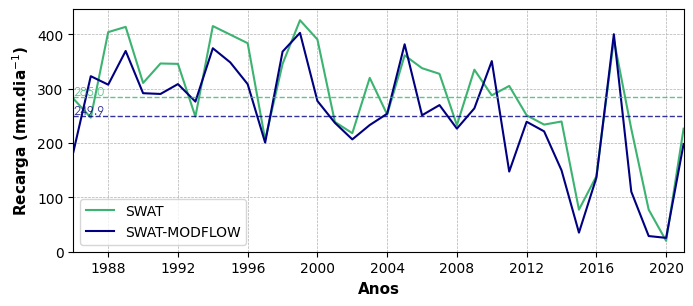

In [100]:
#Configurando a figura em centímetros
cm = 1/2.54
plt.figure(figsize=(20*cm, 8*cm))

cor_swat = 'mediumseagreen'
cor_mod = 'navy'

plt.plot(rch_annually.index, rch_annually['rch_swat'], color=cor_swat, lw=1.5, ls='-', label='SWAT')
plt.plot(rch_annually_mod.index, rch_annually_mod['rch_modflow (mm/dia)'], color=cor_mod, lw=1.5, ls='-', label='SWAT-MODFLOW')

plt.ylabel('Recarga (mm.dia$^{-1}$)', fontsize=11, weight='bold')
plt.xlabel('Anos', fontsize=11, weight='bold')
plt.ylim(0, None)
plt.xlim(rch_annually_mod.index.min(), rch_annually_mod.index.max())
plt.legend()
plt.grid(True, lw=0.5, ls='--')
# plt.title('RECARGA (MODFLOW)', fontsize=14, weight='bold')


#Configurando a média e a linha que representa a média --> modelo SWAT
media_swat = rch_annually['rch_swat'].mean().round(1)
plt.axhline(y=media_swat, color=cor_swat, lw=1.0, ls='--', alpha=0.8, label='média')
plt.text(rch_annually.index.min(), media_swat, f'{media_swat}', va='bottom', ha='left', color=cor_swat, fontsize=9, fontweight='light', alpha=0.8, fontname='Century Gothic')

#Configurando a média e a linha que representa a média --> modelo SWAT-MODFLOW
media_mod = rch_annually_mod['rch_modflow (mm/dia)'].mean().round(1)
plt.axhline(y=media_mod, color=cor_mod, lw=1.0, ls='--', alpha=0.8, label='média')
plt.text(rch_annually_mod.index.min(), media_mod, f'{media_mod}', va='bottom', ha='left', color=cor_mod, fontsize=9, fontweight='light', alpha=0.8, fontname='Century Gothic')

#Salvando a figura
plt.savefig(results_path + 'plot_rec_anual_comp.png', facecolor='w', bbox_inches='tight', dpi=300)

plt.show()

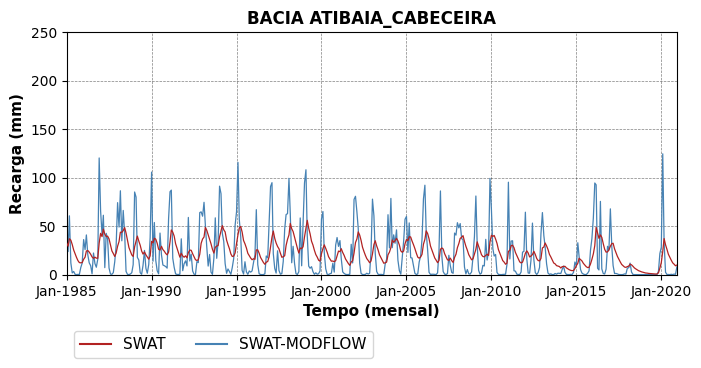

In [101]:
# Gráfico de comparação
cm = 1/2.54
fig, ax1 = plt.subplots(figsize=(20*cm, 8*cm))

cor_swat = 'firebrick'    # 'mediumseagreen'
cor_mod = 'steelblue'    # 'navy'
lw = 0.9
ls = '-'
alpha = 1.0

plt.plot(rch_hru_swat['Date'], rch_hru_swat['rch_swat'], color=cor_swat, lw=lw, ls=ls, alpha=alpha, label='SWAT', zorder=3)
plt.plot(rch_cell_mod['Date'], rch_cell_mod['rch_modflow (mm/dia)'], color=cor_mod, lw=lw, ls=ls, alpha=alpha, label='SWAT-MODFLOW', zorder=2)

plt.ylabel('Recarga (mm)', fontsize=11, weight='bold')
plt.xlabel('Tempo (mensal)', fontsize=11, weight='bold')
plt.ylim(0, 250)
plt.xlim(rch_cell_mod['Date'].min(), rch_cell_mod['Date'].max())
plt.xticks(rotation=0)
plt.grid(True, color='k', lw=0.5, ls='--', alpha=0.5, zorder=1)

plt.title(f'BACIA {bacia.upper()}', fontsize=12, weight='bold')


#Configurando os rótulos dos ticks de datas
#Os ticks principais a cada x anos (base) e mostrando o mês especificado por meio do argumento "month"
ax1.xaxis.set_major_locator(mdates.YearLocator(base=5, month=1))    # ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
#O texto no eixo x será mostrado no formato 'mm-YYYY'
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))


#Legenda
leg1 = plt.legend(loc='upper left', bbox_to_anchor=(0, -0.2), fontsize=11, alignment='left', ncols=2, frameon=True)

for line in leg1.get_lines():
    line.set_linewidth(1.5)

#Salvando a figura
plt.savefig(results_path + 'plot_rec_comp_modelos.png', facecolor='w', bbox_inches='tight', dpi=300)

plt.show()

In [102]:
print(f'Media 1: {media_1}\nMédia 2: {media_2}')

Media 1: 20.8
Média 2: 23.8


In [103]:
print('Neste ponto em 15/01/2025')    # Neste ponto em 19/12/2024

Neste ponto em 15/01/2025


## Séries para o teste KS

In [104]:
data_frame = pd.merge(rch_hru_swat, rch_cell_mod, how='left', on='Date')

data_frame.set_index('Date', inplace=True)
data_frame.rename(columns={'rch_swat': 'rec_swat',
                           'rch_modflow (mm/dia)': 'rec_modflow'}, inplace=True)

path_kstest_folder = 'D:/projetos_qswatmod/series_kstest/'
# data_frame.to_csv(path_kstest_folder + 'serie_temp_' + f'{bacia}' + '.csv', index=False)

data_frame

,rec_swat,rec_modflow
Date,,
1985-01-01,32.663410,61.816869
1985-02-01,29.333265,23.797463
1985-03-01,37.029444,60.618605
1985-04-01,35.525552,12.069855
1985-05-01,31.003814,1.752670
...,...,...
2020-08-01,14.962419,0.358570
2020-09-01,12.193587,0.064441
2020-10-01,10.799592,0.563954


In [105]:
print(f'{rch_hru_swat.head()}\n\n{rch_cell_mod.head()}')

        Date   rch_swat
0 1985-01-01  32.663410
1 1985-02-01  29.333265
2 1985-03-01  37.029444
3 1985-04-01  35.525552
4 1985-05-01  31.003814

        Date  rch_modflow (mm/dia)
0 1985-01-01             61.816869
1 1985-02-01             23.797463
2 1985-03-01             60.618605
3 1985-04-01             12.069855
4 1985-05-01              1.752670
